<a href="https://colab.research.google.com/github/pharringtonp19/business-analytics/blob/main/notebooks/regression/casuality_motivation_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import Libraries**

In [46]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt

### **Helper Functions**

In [47]:
def expected_outcome(d, x):
  return 10_000*d + jnp.dot(jnp.array([-2, -1, 0, 1, 2]), x)*20_000 + 75_000

def expected_treatment(x):
  ps = jnp.array([0.3, 0.4, 0.5, 0.6, 0.7])
  p = jnp.dot(x, ps)
  return p

def sample(key):
  k1, k2, k3 = jax.random.split(key, 3)
  x = jax.nn.one_hot(jax.random.choice(k2, jnp.array([0, 1, 2, 3, 4])),5)
  propensity_score = expected_treatment(x)
  d = jax.random.bernoulli(k2, propensity_score).astype(jnp.float32)
  y = expected_outcome(d, x) + jax.random.normal(k3)*10
  y1 = expected_outcome(jnp.ones_like(d), x) + jax.random.normal(k3)*10
  y0 =  expected_outcome(jnp.zeros_like(d), x) + jax.random.normal(k3)*10
  return y1, y0, y, d, x

### **Sample Data**

In [48]:
data = jax.vmap(sample)(jax.random.split(jax.random.PRNGKey(0), 5000))

df = pd.DataFrame({'Y1': data[0],
                   'Y0': data[1],
                   'Outcome': data[2], 'Treatment': data[3]})
for i in range(5):
  df[f'X{i}'] = data[4][:,i]

In [49]:
df.head()

,Y1,Y0,Outcome,Treatment,X0,X1,X2,X3,X4
0,65007.757812,55007.757812,65007.757812,1.0,0.0,1.0,0.0,0.0,0.0
1,64992.203125,54992.203125,54992.203125,0.0,0.0,1.0,0.0,0.0,0.0
2,85002.187500,75002.187500,85002.187500,1.0,0.0,0.0,1.0,0.0,0.0
3,104997.773438,94997.773438,94997.773438,0.0,0.0,0.0,0.0,1.0,0.0
4,84992.968750,74992.968750,84992.968750,1.0,0.0,0.0,1.0,0.0,0.0


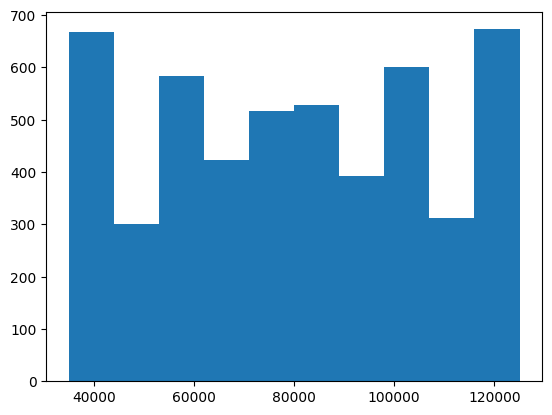

In [50]:
plt.hist(df['Outcome'])
plt.show()

### **Compute Difference in Means**

In [51]:
means = df.groupby('Treatment')['Outcome'].mean()
print(f'The difference in means is: ${means.loc[1.0] - means.loc[0.0]:.0f}')

The difference in means is: $24576


### **Average Treatment on the Treated**

In [52]:
treated_df = df[df['Treatment'] == 1]
ATT = treated_df['Y1'].mean() - treated_df['Y0'].mean()
print(ATT)

9999.992


### **Selection Bias**

In [55]:
means_y0 = df.groupby('Treatment')['Y0'].mean()
selction_bias = means_y0.loc[1.0] - means_y0[0.0]
print(selction_bias)

14575.859


### **ATT + Selection Bias**

In [56]:
ATT + selction_bias

24575.852

### **The Need for Controls**

In [64]:
estimate = 0
variables = ['X0', 'X1', 'X2', 'X3', 'X4']
for var in variables:
  df_temp = df[df[var] == 1]
  weight = len(df_temp) / len(df)
  effect = df_temp.groupby('Treatment')['Outcome'].mean().loc[1.0] - df_temp.groupby('Treatment')['Outcome'].mean().loc[0.0]
  estimate += weight*effect
print(estimate)

10000.23229453125
